# Simple one-way ANOVA 
- 07/28/2022
- HILICpos
- TIC normalized dataset

# load library

In [58]:
# Let the middle rows included.
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [59]:
library(dplyr)
library(car)
library(glue)
source("../utilis/utilis.R") # merge_by_rowName

## Read data table

In [60]:
exp_label = 'PS_species_v2_hMinImp_TICnorm_groupFil0.3_HILICpos'

In [61]:
feat_df = read.csv("../../../output/preprocessing_on_targeted_empd-neutral-matched2/PS-labeled_FC_log2_hMinImp_TICnorm_groupFil0.3_HILICpos_featab.csv", row.names = 1)

In [62]:
head(feat_df)

,formula,neutral_mass,short_name,ion_relation,interium_id,id_number,mz,rtime,rtime_left_base,rtime_right_base,parent_masstrack_id,peak_area,cSelectivity,goodness_fitting,snr,detection_counts,Naive_percNA,Naive_mean,R5neg_percNA,R5neg_mean,R5pos_percNA,R5pos_mean,gMean_Naive,gMean_R5neg,gMean_R5pos,log2FC_R5negvsNaive,log2FC_R5posvsNaive,log2FC_R5posvsR5neg,Naive_1,Naive_2,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3,nist,q3June2014_1,q3June2014_2
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F12,,NA,,,,F12,85.0647,62.21,59.06,64.84,2,4204718,1.00,0.93,39,12,0.0000000,220033.7,0,272870.8,0,115370.7,17.59538,18.34450,16.47684,0.7491156,-1.11854224,-1.8676579,17.32893,17.49848,17.95874,18.26230,18.00141,18.76979,16.50376,16.40300,16.52377,NA,NA,NA
F13,,NA,,,,F13,85.0647,65.10,64.84,67.47,2,1247893,1.00,0.87,27,12,0.0000000,93287.0,0,169408.8,0,99903.0,16.27351,17.56878,16.23475,1.2952758,-0.03875662,-1.3340325,17.04856,15.43534,16.33662,18.23841,16.74748,17.72045,15.76916,16.82645,16.10865,NA,NA,NA
F22,,NA,,,,F22,85.0840,62.21,59.06,64.84,8,66213594,0.77,0.99,16,24,0.0000000,1601571.0,0,1715152.2,0,1524316.3,20.42693,21.01752,20.14052,0.5905903,-0.28640867,-0.8769989,19.87360,20.56377,20.84342,20.89855,20.89947,21.25453,19.51054,20.07431,20.83670,20.38299,21.23263,21.00293
F23,,NA,,,,F23,115.0753,26.74,25.17,29.11,1363,12664086,1.00,0.95,41,19,0.0000000,1528934.0,0,2106183.2,0,2207170.0,20.45122,21.27945,20.59682,0.8282275,0.14559648,-0.6826310,20.57685,20.56563,20.21117,20.96700,21.07304,21.79830,21.26521,20.50973,20.01551,20.32425,18.75317,18.99713
F41,,NA,,,,F41,86.0502,59.32,56.17,62.48,19,8821107,1.00,0.96,109,7,0.6666667,453107.0,0,707319.5,1,NA,18.12283,19.74451,17.78949,1.6216807,-0.33333333,-1.9550141,17.78949,18.78949,17.78949,19.75690,19.61354,19.86308,17.78949,17.78949,17.78949,NA,NA,NA
F42,,NA,,,,F42,86.0502,68.78,66.94,71.67,19,2102676,0.72,0.75,45,7,0.6666667,93720.0,0,482646.0,1,NA,15.84940,19.16350,15.51607,3.3140971,-0.33333333,-3.6474305,15.51607,16.51607,15.51607,19.27638,18.69453,19.51959,15.51607,15.51607,15.51607,NA,NA,NA


##### Check the data, make sure it is already log2-transformed

In [63]:
data.df.log2 = feat_df[,grep('Naive\\_[0-9]+|R5[a-z]+\\_[0-9]+',colnames(feat_df))]

## Read metadata

In [64]:
meta_df = read.csv("../../../input/sequence_file/clean_meta_df_wt1_HILICpos.csv", row.names = 1)

In [65]:
# since the meta_df originally have techincal replicates, which is not unique after technical replicate summaries
# Thus processing metadata a little bit to retain only relevant rows
sub_meta_df <- meta_df[c('tID_dedup','class','biological_samples','cell_number')]
sub_meta_df <- unique(sub_meta_df)

rownames(sub_meta_df) = sub_meta_df$tID_dedup
sub_meta_df = sub_meta_df[colnames(data.df.log2),]
meta_df = sub_meta_df

In [66]:
write.csv(meta_df,"../../../input/sequence_file/clean_deduplicated_meta_df.csv", row.names = FALSE)

------

# Summary
- check if the metadata & data matched (It should be as they have been filtered in the last notebook)
- check key metadata

In [67]:
nrow(meta_df) == ncol(data.df.log2)

[1] TRUE

In [68]:
table(meta_df['class'])

class
Naive R5neg R5pos 
    3     3     3 

### Transpose the table and prepare to merge with meta data

In [69]:
data_df.t = t(data.df.log2) # transpose the table

In [70]:
data_df.t[1:5,1:5]

,F12,F13,F22,F23,F41
Naive_1,17.32893,17.04856,19.87360,20.57685,17.78949
Naive_2,17.49848,15.43534,20.56377,20.56563,18.78949
Naive_3,17.95874,16.33662,20.84342,20.21117,17.78949
R5neg_1,18.26230,18.23841,20.89855,20.96700,19.75690
R5neg_2,18.00141,16.74748,20.89947,21.07304,19.61354


In [71]:
ft_names = colnames(data_df.t);ft_names[1:5]

[1] "F12" "F13" "F22" "F23" "F41"

In [72]:
meta_df[1:5,]

,tID_dedup,class,biological_samples,cell_number
,<chr>,<chr>,<chr>,<int>
Naive_1,Naive_1,Naive,Yes,300
Naive_2,Naive_2,Naive,Yes,300
Naive_3,Naive_3,Naive,Yes,300
R5neg_1,R5neg_1,R5neg,Yes,655
R5neg_2,R5neg_2,R5neg,Yes,687


----

------

# Simple one-way ANOVA
- Run all gated populations
- `ft_names`

## Prepare for the table

In [73]:
prep4anova_df = merge_by_rowName(data_df.t, meta_df) # merge data table and metadata

In [74]:
prep4anova_df_filt <- prep4anova_df[,c(
    colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
    c('class') # + critical study design factors
)] # select the columns

In [75]:
prep4anova_df_filt[1:9,c(ncol(prep4anova_df_filt)-1, ncol(prep4anova_df_filt))]

,F18900,class
,<dbl>,<chr>
Naive_1,16.79993,Naive
Naive_2,17.65322,Naive
Naive_3,16.35093,Naive
R5neg_1,15.13238,R5neg
R5neg_2,17.63214,R5neg
R5neg_3,17.01757,R5neg
R5pos_1,13.62873,R5pos
R5pos_2,15.36516,R5pos
R5pos_3,14.20427,R5pos


## Run ANOVA

In [76]:
anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
    return(tryCatch(
        aov(x ~ prep4anova_df[,'class']), # no var.equal as the argument will be disregarded.
        error=function(e) NULL))
})

## Wrap ANOVA result into table

In [77]:
anova_res_list2table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Turn one-way Anova result into table
    temp_row_list <- list()
    for (i in 1:length(anova_res_list)) {
      if(is.null(anova_res_list[[i]])) {
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]),0,1) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      } else {
        anova_res.summary <- summary(anova_res_list[[i]])
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]), anova_res.summary[[1]]['F value'][[1]][1], anova_res.summary[[1]]['Pr(>F)'][[1]][1])
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      }
    }
    anova_res_df = do.call(rbind, temp_row_list)
    anova_res_df$padj <- p.adjust(anova_res_df$pval, method = 'BH') 

    anova_res_df = data.frame(anova_res_df)
    rownames(anova_res_df) = anova_res_df[,1]
    anova_res_df = anova_res_df[,2:ncol(anova_res_df)]
    return(anova_res_df)
}

#### debugging run

In [78]:
# anova_res_df = anova_res_list2table(anova_res_list, "featureID")
# dim(anova_res_df) # the dimension should be the same with original table

## Run tukey test on the `anova_res_list`

In [79]:
anova_res_list2tukeytest_table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Perform tukey test and generate the table from anova result list
    # Also current function only deals with one variable, for 2-way anova or multivariate regression, this function cannot implement
    temp_row_list <- list()
    
    # search for a valid result to get template for set up the NA stuffs
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        
        obj_list = ls(tukey.test) # There will only be one if it is 1-way anova
        obj = obj_list[[1]]
        
        tukey_oriTab = tukey.test[[obj]]
        
        padj_col_names = paste0('Tpadj_',rownames(tukey_oriTab))
        colnames = c(name_of_variable,padj_col_names)
        
        length = dim(tukey_oriTab)[1]
        
        break
        }
    } 
    
    # then go for the real run
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        tukey_oriTab = tukey.test[[obj]]
        temp_row_list[[i]] <- c(names(anova_res_list[i]), 
                                tukey_oriTab[,4] )
        } 
        else 
        {
        temp_row_list[[i]] <- c(names(anova_res_list[i]),
                                rep(NA,length) ) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        
      }
    }
    tukey_res_df = do.call(rbind, temp_row_list)
    colnames(tukey_res_df) = colnames
    
    # handling the fickled things about numeric
    tukey_res_df = data.frame(tukey_res_df)
    rownames = tukey_res_df[,1]
    tukey_res_df = tukey_res_df[,2:ncol(tukey_res_df)]
    tukey_res_df = sapply(tukey_res_df, as.numeric)
    tukey_res_df = data.frame(tukey_res_df)
    rownames(tukey_res_df) = rownames
    
    # correction of Tukey post-hoc stat as well
    Tpadj_cols = colnames(tukey_res_df)[grepl('Tpadj',colnames(tukey_res_df))]
    for (Tpadj_col in Tpadj_cols) {
        tukey_res_df[,gsub('Tpadj','TFDR',Tpadj_col)] <- p.adjust(tukey_res_df[,Tpadj_col], method = 'BH')
    }

    
    # For tukey test, no need to do another round of FDR
    return(tukey_res_df)
}

#### debugging run

In [80]:
# tukey_res_df = anova_res_list2tukeytest_table(anova_res_list,"featureID")

# dim(tukey_res_df)

# aov_tuk_df = merge(anova_res_df,tukey_res_df, by.x = 0, by.y = 0)

# # check if rownames of both table to be merged is the same
# all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)

# dim(aov_tuk_df)
# colnames(aov_tuk_df)

# Wrapper function

In [81]:
oneway_anova_tukey_analysis <- function(data_df = data_df.t,
                                     meta_df = meta_df,
                                     name_of_class = 'class',
                                     name_of_variable = 'featureID') {
    # always observations as rows, subjects as columns
    # Here only suports 1-way anova which has only one variable
    
    prep4anova_df = merge_by_rowName(data_df, meta_df) # merge data table and metadata
    ft_names = colnames(data_df)
    prep4anova_df_filt <- prep4anova_df[,c(
        colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
        name_of_class)] # select the columns
    
    anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
                        return(tryCatch(
                            aov(x ~ prep4anova_df[,name_of_class]), # no var.equal as the argument will be disregarded.
                            error=function(e) NULL))
                        })
    anova_res_df = anova_res_list2table(anova_res_list, name_of_variable)
    tukey_res_df = anova_res_list2tukeytest_table(anova_res_list, name_of_variable)
    
    # check if rownames of both table to be merged is the same
    msg_check_rowName = all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)
    print(glue('Row name of ANOVA & tukeyTest table is the same? :{msg_check_rowName}'))                           
    
    aov_tuk_df = merge_by_rowName(anova_res_df,tukey_res_df)

    return(aov_tuk_df) # debug: list(anova_res_df,tukey_res_df)
}

In [82]:
aov_tuk_df <- oneway_anova_tukey_analysis(data_df = data_df.t,
                            meta_df = meta_df,
                            name_of_class = 'class',
                            name_of_variable = 'featureID')


Row name of ANOVA & tukeyTest table is the same? :TRUE


In [83]:
head(aov_tuk_df)

,f_score,pval,padj,Tpadj_R5neg.Naive,Tpadj_R5pos.Naive,Tpadj_R5pos.R5neg,TFDR_R5neg.Naive,TFDR_R5pos.Naive,TFDR_R5pos.R5neg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F10003,18.6326486,0.002667072,0.01908728,0.008004955,0.5828549,0.002968608,0.06008466,1,0.02259984
F10020,13.8958783,0.005597852,0.02827235,0.086349193,0.0854230,0.004521396,0.26236142,1,0.02749508
F1004,0.3782372,0.700314849,0.75685353,0.921033067,0.6780556,0.883448556,1.00000000,1,0.96695497
F10040,13.3264017,0.006204293,0.03021458,0.012739912,0.9106937,0.008230900,0.07775836,1,0.03833248
F10041,0.5635618,0.596637979,0.67250247,0.626273031,0.9959176,0.675150454,0.82835445,1,0.81447188
F10043,3.3162487,0.107148503,0.19367808,0.187205217,0.9292218,0.117281865,0.40432241,1,0.22507462


In [84]:
colnames(aov_tuk_df)

[1] "f_score"           "pval"              "padj"             
[4] "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive" "Tpadj_R5pos.R5neg"
[7] "TFDR_R5neg.Naive"  "TFDR_R5pos.Naive"  "TFDR_R5pos.R5neg"

In [85]:
dim(aov_tuk_df)

[1] 2771    9

----

In [86]:
histogram_p <- function(stat_df,p_label, title_label) {
    par(mar=c(10,5,4,1))
    par(mfrow=c(2,2))
    pval_col_list = colnames(stat_df)[grepl(p_label, colnames(stat_df), fixed=TRUE)]
    print(pval_col_list)
    for (pval_col in pval_col_list) {
        hist(stat_df[,pval_col],
             col = 'skyblue3', 
             breaks = 20, 
             xlab=pval_col, 
             main=paste0(title_label,'\n',gsub(p_label,'',pval_col)))
    }
}

[1] "padj"              "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive"
[4] "Tpadj_R5pos.R5neg"


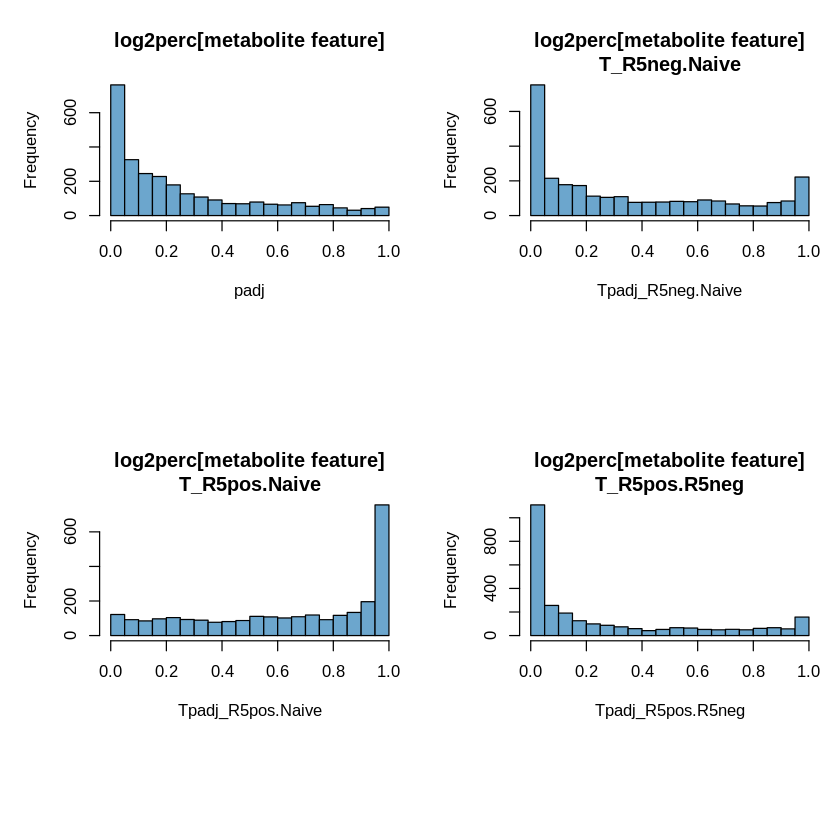

In [87]:
histogram_p(aov_tuk_df,'padj','\nlog2perc[metabolite feature]')

[1] "TFDR_R5neg.Naive" "TFDR_R5pos.Naive" "TFDR_R5pos.R5neg"


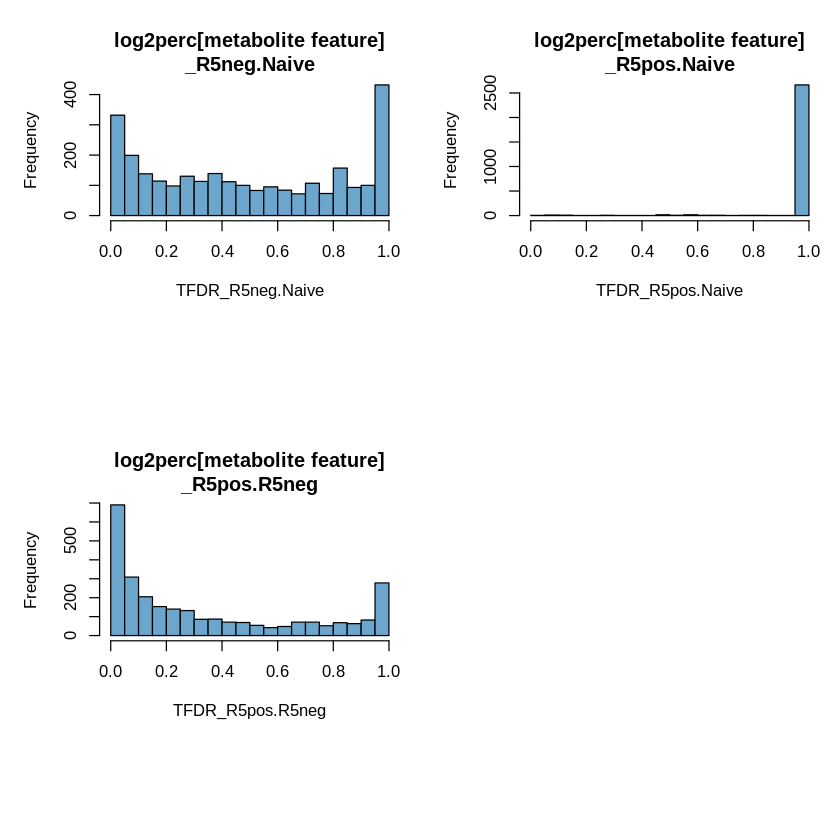

In [88]:
histogram_p(aov_tuk_df,'TFDR','\nlog2perc[metabolite feature]')

[1] "pval"


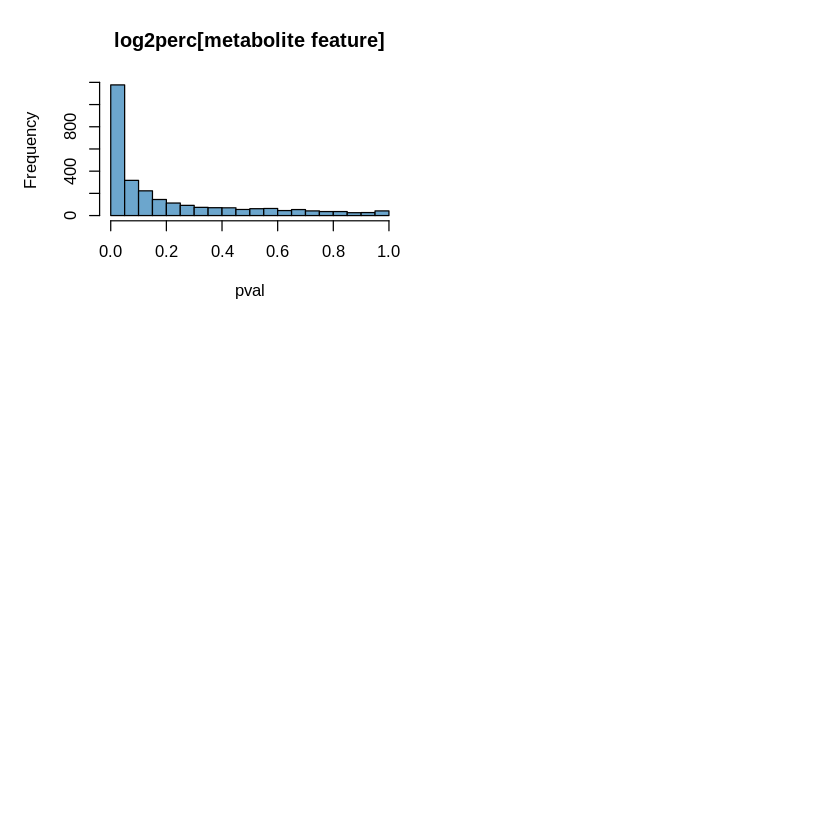

In [89]:
histogram_p(aov_tuk_df,'pval','\nlog2perc[metabolite feature]')

In [90]:
colnames(aov_tuk_df)

[1] "f_score"           "pval"              "padj"             
[4] "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive" "Tpadj_R5pos.R5neg"
[7] "TFDR_R5neg.Naive"  "TFDR_R5pos.Naive"  "TFDR_R5pos.R5neg"

In [91]:
sign_df = aov_tuk_df[(aov_tuk_df$padj < 0.05),]
sign_df[1:10,]

,f_score,pval,padj,Tpadj_R5neg.Naive,Tpadj_R5pos.Naive,Tpadj_R5pos.R5neg,TFDR_R5neg.Naive,TFDR_R5pos.Naive,TFDR_R5pos.R5neg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F10003,18.63265,0.0026670716,0.019087282,0.008004955,0.5828549,0.002968608,0.06008466,1,0.02259984
F10020,13.89588,0.0055978525,0.028272354,0.086349193,0.0854230,0.004521396,0.26236142,1,0.02749508
F10040,13.32640,0.0062042934,0.030214582,0.012739912,0.9106937,0.008230900,0.07775836,1,0.03833248
F10048,10.01326,0.0122519477,0.046253607,0.079393292,0.2657568,0.010378615,0.24971488,1,0.04465705
F10141,25.41719,0.0011765774,0.010977427,0.005011450,0.2885711,0.001170360,0.04523364,1,0.01237812
F10201,15.17024,0.0045007147,0.025193002,0.011865039,0.7125167,0.005216290,0.07427650,1,0.02943857
F10204,32.25314,0.0006162692,0.006973421,0.001069167,1.0000000,0.001069167,0.01438185,1,0.01171012
F10243,28.54620,0.0008600475,0.008826636,0.001481687,1.0000000,0.001481687,0.01754596,1,0.01482222
F10257,19.68766,0.0023120371,0.017908562,0.019326707,0.1251065,0.001948963,0.10046639,1,0.01749389


In [92]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.05,])[1]

[1] 762

In [93]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.1,])[1]

[1] 1088

In [94]:
dim(aov_tuk_df[aov_tuk_df$pval < 0.05,])[1] # check raw p value

[1] 1177

-------

----

# construct the final result tables

In [95]:
detect_boundary_index = function(feat_df = feat_df,
                                 Data_RegExpr = '\\_[0-9]+'
                                ) {
    # the output index is the last index for the metainfo
    first_index4data = grep(Data_RegExpr,colnames(feat_df))[1]
    # range = colnames(feat_df)[first_index4data - 1:first_index4data + 1]
    print(colnames(feat_df)[first_index4data-1])
    return(first_index4data-1)
}

In [96]:
wrap_res2ful <- function(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index) {
    metainfo_df = feat_df[,1:end_index]
    metainfo_df = merge_by_rowName(metainfo_df,aov_tuk_df) # use merge by rowname in utilis
    m_df = merge_by_rowName(metainfo_df,
                 feat_df[(end_index + 1):ncol(feat_df)]) # use merge by rowname in utilis
    return(m_df)
}
    

In [97]:
metainfo_end_index = detect_boundary_index(feat_df = feat_df, 
                                           Data_RegExpr = '\\_[0-9]+')
full_res_df <- wrap_res2ful(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index)

[1] "log2FC_R5posvsR5neg"


In [98]:
dim(full_res_df)

[1] 2771   49

In [99]:
colnames(full_res_df)

[1] "formula"             "neutral_mass"        "short_name"         
 [4] "ion_relation"        "interium_id"         "id_number"          
 [7] "mz"                  "rtime"               "rtime_left_base"    
[10] "rtime_right_base"    "parent_masstrack_id" "peak_area"          
[13] "cSelectivity"        "goodness_fitting"    "snr"                
[16] "detection_counts"    "Naive_percNA"        "Naive_mean"         
[19] "R5neg_percNA"        "R5neg_mean"          "R5pos_percNA"       
[22] "R5pos_mean"          "gMean_Naive"         "gMean_R5neg"        
[25] "gMean_R5pos"         "log2FC_R5negvsNaive" "log2FC_R5posvsNaive"
[28] "log2FC_R5posvsR5neg" "f_score"             "pval"               
[31] "padj"                "Tpadj_R5neg.Naive"   "Tpadj_R5pos.Naive"  
[34] "Tpadj_R5pos.R5neg"   "TFDR_R5neg.Naive"    "TFDR_R5pos.Naive"   
[37] "TFDR_R5pos.R5neg"    "Naive_1"             "Naive_2"            
[40] "Naive_3"             "R5neg_1"             "R5neg_2"            
[43] "R5neg_3"             "R5pos_1"             "R5pos_2"            
[46] "R5pos_3"             "nist"                "q3June2014_1"       
[49] "q3June2014_2"

## output

In [100]:
output_fdr = glue('../../../output/{exp_label}_1wayANOVA/')
dir.create(output_fdr)

Warning message in dir.create(output_fdr):
“'../../../output/PS_species_v2_hMinImp_TICnorm_groupFil0.3_HILICpos_1wayANOVA' already exists”


In [101]:
write.csv(full_res_df,
          file.path(output_fdr, 
                    glue('one_wayANOVA_{exp_label}_fullreport.csv')))

------

In [102]:
col_stat_score = colnames(feat_df)[grep('log2FC',colnames(feat_df))]

In [103]:
col_stat_score

[1] "log2FC_R5negvsNaive" "log2FC_R5posvsNaive" "log2FC_R5posvsR5neg"

In [104]:
col_padj_stat = colnames(aov_tuk_df)[grep('Tpadj',colnames(aov_tuk_df))]

In [105]:
col_padj_stat

[1] "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive" "Tpadj_R5pos.R5neg"

In [106]:
grepl('R5neg(\\.|vs)Naive',col_padj_stat)

[1]  TRUE FALSE FALSE

In [107]:
contrast_regExprs = c('R5neg(\\.|vs)Naive',
                      'R5pos(\\.|vs)Naive',
                      'R5pos(\\.|vs)R5neg')

res2mcg_tukey <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # Use log2FC as stat and padj/TFDR from tukey test for p cutoff
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        
        true_label = strsplit(stat_col,'_')[[1]][2]
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [108]:
res2mcg_tukey(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

## 2-steps to control tukey stat


In [109]:
res2mcg_tukey_2steps <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # With 2 steps, the data go after Tpadj, 
    # but turn to 1 if the feature didn't pass the 1-way ANOVA FDR
    # Use log2FC as stat and padj from tukey test for p cutoff
    
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        
        true_label = strsplit(stat_col,'_')[[1]][2] # just quick way to get the contrast
        
        mcg_df[glue("org_{padj_col}")] = mcg_df[padj_col]
        mcg_df[mcg_df$padj > 0.05, padj_col] = 1
        
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_2steps_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [110]:
res2mcg_tukey_2steps(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

------

## Summary: normal one-way ANOVA
- with Tukey post-hoc test
- Run through all the contrast